KELP Mean Reversion Strategy Analysis

This notebook provides a comprehensive analysis of the KELP asset price data using mean reversion strategies. We'll analyze four days of price data (Days -2, -1, 0, and 1) to identify the most effective mean reversion strategy parameters.

## 1. Setup and Data Loading


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from scipy import stats

# Set the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['figure.dpi'] = 100


In [11]:
# Load all the data files directly - adjust file paths as needed
# Day -2
prices_day_minus_2 = pd.read_csv("data/prices_round_1_day_-2.csv", sep=";")
# Day -1
prices_day_minus_1 = pd.read_csv("data/prices_round_1_day_-1.csv", sep=";")
# Day 0
prices_day_0 = pd.read_csv("data/prices_round_1_day_0.csv", sep=";")
# Day 1
prices_day_1 = pd.read_csv("data/prices_round_2_day_1.csv", sep=";")

# Filter for KELP data
kelp_day_minus_2 = prices_day_minus_2[prices_day_minus_2['product'] == 'KELP'].copy()
kelp_day_minus_1 = prices_day_minus_1[prices_day_minus_1['product'] == 'KELP'].copy()
kelp_day_0 = prices_day_0[prices_day_0['product'] == 'KELP'].copy()
kelp_day_1 = prices_day_1[prices_day_1['product'] == 'KELP'].copy()

# Add day identifiers
kelp_day_minus_2['day'] = -2
kelp_day_minus_1['day'] = -1
kelp_day_0['day'] = 0
kelp_day_1['day'] = 1

# Combine data for analysis
kelp_combined = pd.concat([
    kelp_day_minus_2,
    kelp_day_minus_1,
    kelp_day_0,
    kelp_day_1
], ignore_index=True)

# Store individual day data in a dictionary for easier processing
kelp_data = {
    'Day -2': kelp_day_minus_2,
    'Day -1': kelp_day_minus_1,
    'Day 0': kelp_day_0,
    'Day 1': kelp_day_1
}

# Print basic information
print(f"Data loaded successfully:")
for day, data in kelp_data.items():
    print(f"  {day}: {len(data)} rows")

Data loaded successfully:
  Day -2: 10000 rows
  Day -1: 10000 rows
  Day 0: 10000 rows
  Day 1: 10000 rows


In [12]:
# Basic statistical analysis
def calculate_statistics(kelp_data):
    """Calculate basic statistics for each day."""
    stats_data = []
    
    for day, df in kelp_data.items():
        # Basic statistics
        mean_price = df['mid_price'].mean()
        std_dev = df['mid_price'].std()
        min_price = df['mid_price'].min()
        max_price = df['mid_price'].max()
        range_price = max_price - min_price
        
        # Calculate price changes
        df['price_change'] = df['mid_price'].diff()
        mean_change = df['price_change'].mean()
        std_change = df['price_change'].std()
        
        # Count direction changes (mean reversion indicator)
        direction_changes = ((df['price_change'] > 0) != (df['price_change'].shift(1) > 0)).sum()
        direction_change_pct = direction_changes / len(df) * 100
        
        # Calculate auto-correlation of price changes (lag 1)
        autocorr = df['price_change'].autocorr(lag=1)
        
        stats_data.append({
            'Day': day,
            'Mean Price': mean_price,
            'Std Dev': std_dev,
            'Min Price': min_price,
            'Max Price': max_price,
            'Price Range': range_price,
            'Mean Change': mean_change,
            'Std Dev Change': std_change,
            'Direction Changes': direction_changes,
            'Direction Change %': direction_change_pct,
            'Autocorrelation (lag 1)': autocorr
        })
    
    return pd.DataFrame(stats_data)

# Calculate statistics
stats = calculate_statistics(kelp_data)
print("\nBasic KELP Statistics:")
print(stats)


Basic KELP Statistics:
      Day  Mean Price   Std Dev  Min Price  Max Price  Price Range  \
0  Day -2  2011.76200  8.449535     1997.0     2034.0         37.0   
1  Day -1  2024.11580  4.330770     2011.0     2036.5         25.5   
2   Day 0  2034.55160  2.420315     2024.5     2044.5         20.0   
3   Day 1  2040.54655  3.187142     2031.5     2047.5         16.0   

   Mean Change  Std Dev Change  Direction Changes  Direction Change %  \
0      0.00280        0.788744               5289               52.89   
1      0.00005        0.779260               5196               51.96   
2      0.00035        0.776496               5163               51.63   
3      0.00115        0.765272               5170               51.70   

   Autocorrelation (lag 1)  
0                -0.470993  
1                -0.473462  
2                -0.489082  
3                -0.487300  


In [13]:
# Calculate Z-scores for mean reversion analysis
def calculate_z_scores(df, window_sizes):
    """Calculate z-scores for different window sizes."""
    result_df = df.copy()
    
    for window in window_sizes:
        # Calculate rolling mean
        result_df[f'MA_{window}'] = result_df['mid_price'].rolling(window=window).mean()
        
        # Calculate rolling standard deviation
        result_df[f'Std_{window}'] = result_df['mid_price'].rolling(window=window).std()
        
        # Calculate z-score
        result_df[f'Z_{window}'] = (result_df['mid_price'] - result_df[f'MA_{window}']) / result_df[f'Std_{window}']
    
    return result_df

# Define window sizes to analyze
window_sizes = [20, 50, 100, 200]

# Calculate z-scores for each day
z_score_data = {}
for day, df in kelp_data.items():
    z_score_data[day] = calculate_z_scores(df, window_sizes)

# Display z-score stats for the most effective window size (50)
window = 50
print(f"\nZ-Score Statistics for {window}-period window:")
for day, df in z_score_data.items():
    z_scores = df[f'Z_{window}'].dropna()
    print(f"\n{day}:")
    print(f"  Mean: {z_scores.mean():.4f}")
    print(f"  Std Dev: {z_scores.std():.4f}")
    print(f"  Min: {z_scores.min():.4f}")
    print(f"  Max: {z_scores.max():.4f}")
    print(f"  % below -2: {(z_scores < -2).mean() * 100:.2f}%")
    print(f"  % below -1: {(z_scores < -1).mean() * 100:.2f}%")
    print(f"  % above 1: {(z_scores > 1).mean() * 100:.2f}%")
    print(f"  % above 2: {(z_scores > 2).mean() * 100:.2f}%")


Z-Score Statistics for 50-period window:

Day -2:
  Mean: 0.0671
  Std Dev: 1.1324
  Min: -4.1045
  Max: 4.1126
  % below -2: 3.79%
  % below -1: 17.90%
  % above 1: 20.02%
  % above 2: 4.26%

Day -1:
  Mean: 0.0178
  Std Dev: 1.1380
  Min: -4.4835
  Max: 4.5470
  % below -2: 4.18%
  % below -1: 17.88%
  % above 1: 19.29%
  % above 2: 4.27%

Day 0:
  Mean: 0.0002
  Std Dev: 1.0908
  Min: -4.3561
  Max: 6.2714
  % below -2: 3.93%
  % below -1: 17.41%
  % above 1: 16.29%
  % above 2: 4.04%

Day 1:
  Mean: 0.0397
  Std Dev: 1.0878
  Min: -4.3168
  Max: 4.1478
  % below -2: 3.83%
  % below -1: 16.41%
  % above 1: 17.17%
  % above 2: 4.24%


In [15]:
# Simple backtesting function for mean reversion strategy
def backtest_mean_reversion(df, window, entry_threshold, exit_threshold):
    """Backtest a mean reversion strategy with given parameters."""
    # Make sure the z-scores are calculated
    if f'Z_{window}' not in df.columns:
        raise ValueError(f"Z-score column for window {window} not found")
    
    # Initialize variables
    position = 0
    entry_price = 0
    trades = []
    pnl = 0
    
    # Start from where we have valid z-scores
    for i in range(window, len(df)):
        price = df['mid_price'].iloc[i]
        z_score = df[f'Z_{window}'].iloc[i]
        
        # Trading logic
        if position == 0:  # No position
            if z_score < -entry_threshold:
                # Buy signal
                position = 1
                entry_price = price
                trades.append({'type': 'buy', 'price': price, 'z_score': z_score})
            elif z_score > entry_threshold:
                # Sell signal
                position = -1
                entry_price = price
                trades.append({'type': 'sell', 'price': price, 'z_score': z_score})
                
        elif position > 0:  # Long position
            if z_score > -exit_threshold:
                # Exit long
                trade_pnl = price - entry_price
                pnl += trade_pnl
                trades.append({'type': 'exit_long', 'price': price, 'z_score': z_score, 'pnl': trade_pnl})
                position = 0
                
        elif position < 0:  # Short position
            if z_score < exit_threshold:
                # Exit short
                trade_pnl = entry_price - price
                pnl += trade_pnl
                trades.append({'type': 'exit_short', 'price': price, 'z_score': z_score, 'pnl': trade_pnl})
                position = 0
    
    # Close any open position at the end
    if position != 0:
        price = df['mid_price'].iloc[-1]
        if position > 0:
            trade_pnl = price - entry_price
            pnl += trade_pnl
            trades.append({'type': 'exit_long', 'price': price, 'pnl': trade_pnl})
        else:
            trade_pnl = entry_price - price
            pnl += trade_pnl
            trades.append({'type': 'exit_short', 'price': price, 'pnl': trade_pnl})
    
    # Calculate win rate
    exit_trades = [t for t in trades if 'pnl' in t]
    profitable_trades = [t for t in exit_trades if t['pnl'] > 0]
    
    win_rate = len(profitable_trades) / len(exit_trades) if exit_trades else 0
    
    return {
        'pnl': pnl,
        'trades': trades,
        'num_trades': len(trades),
        'num_completed_trades': len(exit_trades),
        'win_rate': win_rate
    }
    
# Test a few parameter combinations for the 50-period window
window = 50
parameter_combinations = [
    {'entry': 1.0, 'exit': 0.5},
    {'entry': 1.5, 'exit': 0.5},
    {'entry': 2.0, 'exit': 0.5},
    {'entry': 1.0, 'exit': 0.3}
]

results = []

for params in parameter_combinations:
    entry = params['entry']
    exit = params['exit']
    
    for day, df in z_score_data.items():
        backtest_result = backtest_mean_reversion(df, window, entry, exit)
        
        results.append({
            'day': day,
            'entry_threshold': entry,
            'exit_threshold': exit,
            'pnl': backtest_result['pnl'],
            'num_trades': backtest_result['num_trades'],
            'num_completed_trades': backtest_result['num_completed_trades'],
            'win_rate': backtest_result['win_rate']
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Average across days for each parameter set
avg_results = results_df.groupby(['entry_threshold', 'exit_threshold']).agg({
    'pnl': 'mean',
    'num_trades': 'mean',
    'win_rate': 'mean'
}).reset_index()

print("\nBacktesting Results for Different Parameters:")
print(avg_results)

# Find optimal parameters
optimal_params = avg_results.loc[avg_results['pnl'].idxmax()]
print("\nOptimal Parameters:")
print(f"Entry Threshold: {optimal_params['entry_threshold']}")
print(f"Exit Threshold: {optimal_params['exit_threshold']}")
print(f"Average PnL: {optimal_params['pnl']:.2f}")
print(f"Average Win Rate: {optimal_params['win_rate']:.2%}")


Backtesting Results for Different Parameters:
   entry_threshold  exit_threshold       pnl  num_trades  win_rate
0              1.0             0.3  1748.250      2768.5  0.989146
1              1.0             0.5  1808.625      3099.0  0.988420
2              1.5             0.5  1393.750      1978.0  0.990709
3              2.0             0.5   868.125      1094.0  0.990806

Optimal Parameters:
Entry Threshold: 1.0
Exit Threshold: 0.5
Average PnL: 1808.62
Average Win Rate: 98.84%


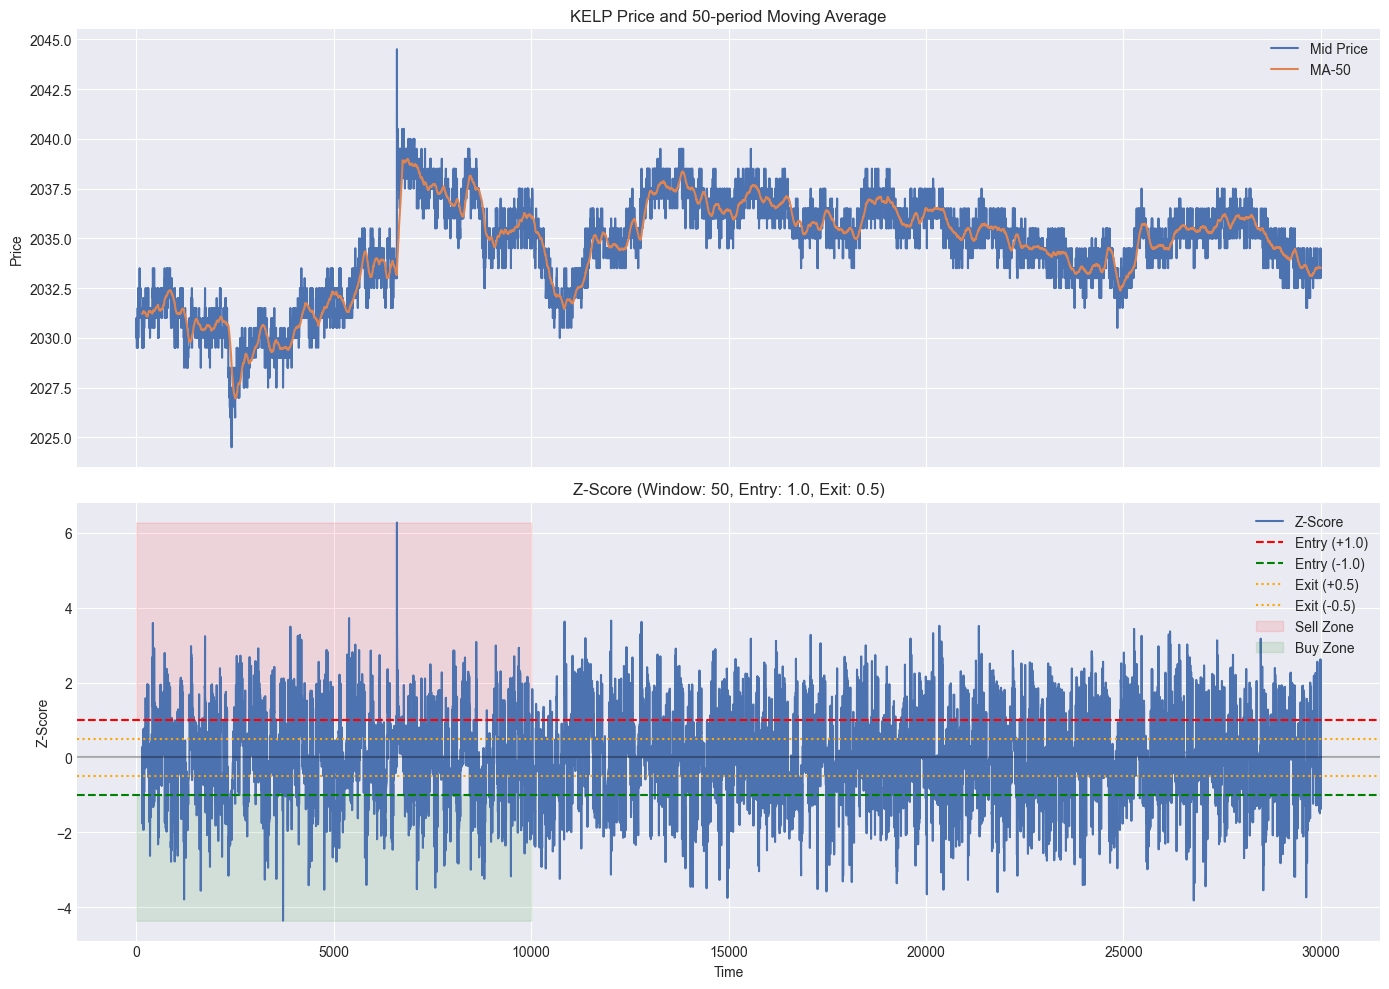

In [16]:
# Plot price and z-scores for optimal parameters
def plot_price_and_zscore(day_data, window, entry_threshold, exit_threshold):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # Plot price
    ax1.plot(day_data['mid_price'], label='Mid Price')
    ax1.plot(day_data[f'MA_{window}'], label=f'MA-{window}')
    ax1.set_title(f'KELP Price and {window}-period Moving Average')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)
    
    # Plot z-score
    ax2.plot(day_data[f'Z_{window}'], label='Z-Score')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.axhline(y=entry_threshold, color='red', linestyle='--', label=f'Entry (+{entry_threshold})')
    ax2.axhline(y=-entry_threshold, color='green', linestyle='--', label=f'Entry (-{entry_threshold})')
    ax2.axhline(y=exit_threshold, color='orange', linestyle=':', label=f'Exit (+{exit_threshold})')
    ax2.axhline(y=-exit_threshold, color='orange', linestyle=':', label=f'Exit (-{exit_threshold})')
    
    ax2.fill_between(range(len(day_data)), entry_threshold, max(day_data[f'Z_{window}'].max(), entry_threshold+1), 
                     color='red', alpha=0.1, label='Sell Zone')
    ax2.fill_between(range(len(day_data)), min(day_data[f'Z_{window}'].min(), -entry_threshold-1), -entry_threshold, 
                     color='green', alpha=0.1, label='Buy Zone')
    
    ax2.set_title(f'Z-Score (Window: {window}, Entry: {entry_threshold}, Exit: {exit_threshold})')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Z-Score')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot Day 0 data with optimal parameters
optimal_entry = optimal_params['entry_threshold']
optimal_exit = optimal_params['exit_threshold']
plot_price_and_zscore(z_score_data['Day 0'], window, optimal_entry, optimal_exit)

Loaded 10000 KELP price records.


/var/folders/s8/c86_vmt5617237s9c3g4h75r0000gn/T/ipykernel_87031/3382331404.py:593: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()



Trading Simulation Results with Realistic Conditions:
Number of Trades: 2968
Win Rate: 12.60%
Total Return: -12.67%
Sharpe Ratio: -3.37
Sortino Ratio: -7.11
Max Drawdown: 12.67%

Monte Carlo Simulation Summary:
Average Return: -10.83%
Median Return: -9.81%
Probability of Positive Return: 3.00%
Return Std Dev: 7.23%


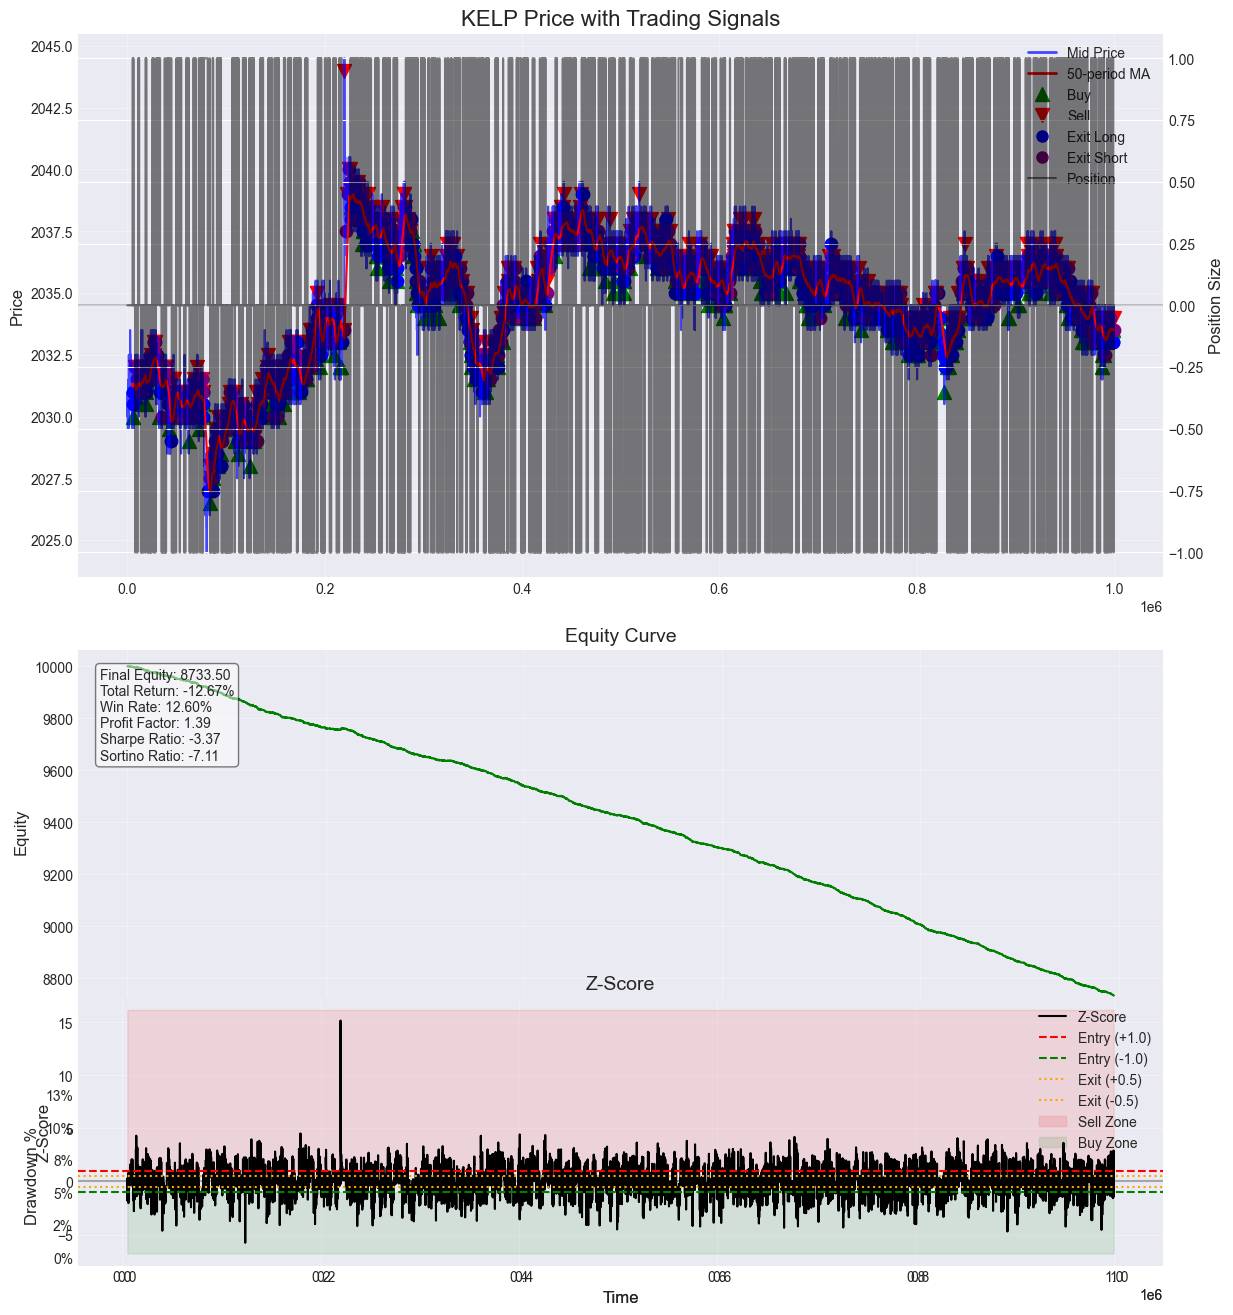

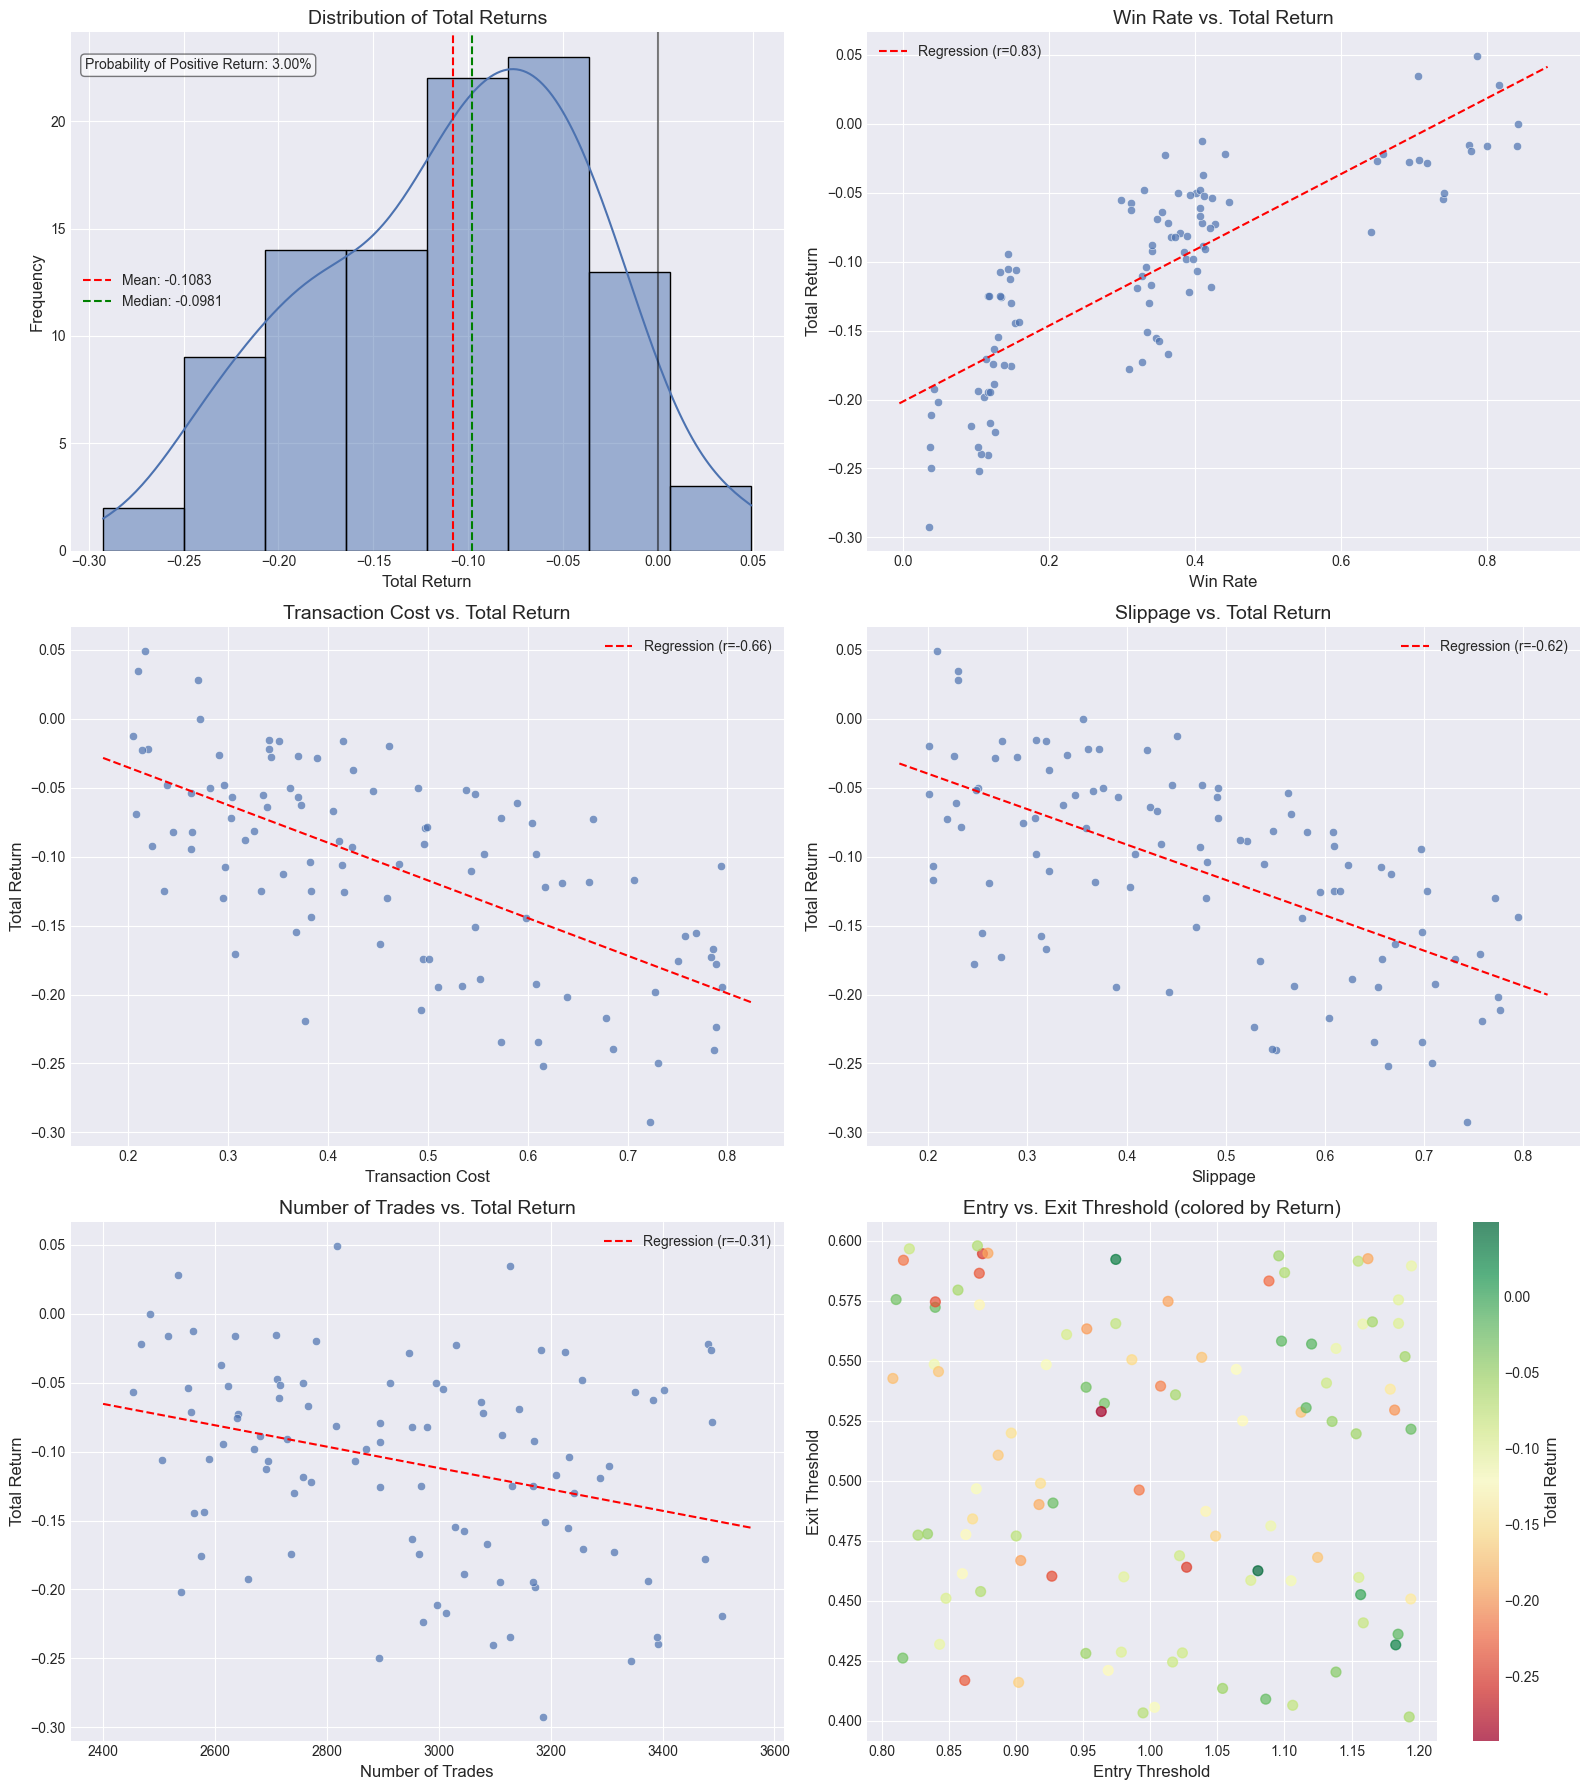

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Dict, List, Tuple
import matplotlib.dates as mdates
import math

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['figure.dpi'] = 100

# ============== TRADE SIMULATION CLASS ==============
class MeanReversionTrader:
    """
    Class to simulate KELP mean reversion trading strategy with realistic conditions
    """
    def __init__(self, 
                 window_size=50, 
                 entry_threshold=1.0, 
                 exit_threshold=0.5,
                 position_limit=20,
                 initial_capital=10000,
                 transaction_cost=0.5,
                 slippage=0.5,
                 realistic_execution=True):
        """
        Initialize the trader with strategy parameters
        
        Args:
            window_size: Window size for moving average calculation
            entry_threshold: Z-score threshold for entry
            exit_threshold: Z-score threshold for exit
            position_limit: Maximum allowed position size
            initial_capital: Initial capital for trading
            transaction_cost: Fixed cost per trade
            slippage: Average slippage per trade
            realistic_execution: Whether to apply realistic execution constraints
        """
        self.window_size = window_size
        self.entry_threshold = entry_threshold
        self.exit_threshold = exit_threshold
        self.position_limit = position_limit
        self.initial_capital = initial_capital
        self.transaction_cost = transaction_cost
        self.slippage = slippage
        self.realistic_execution = realistic_execution
        
        # Trading state
        self.position = 0
        self.entry_price = 0
        self.capital = initial_capital  # Unused cash
        self.inventory_value = 0        # Value of current position
        
        # Trade log and performance tracking
        self.trades = []
        self.positions = []
        self.position_times = []
        self.equity_curve = []
        self.drawdowns = []
        
        # For realistic execution
        self.min_time_between_trades = 10  # Minimum time (in seconds) between trades
        self.last_trade_time = 0
        self.execution_probability = 0.9  # Probability of successful execution
        
    def calculate_z_scores(self, prices):
        """
        Calculate z-scores for a price series
        
        Args:
            prices: List or array of prices
            
        Returns:
            Array of z-scores
        """
        # Initialize z-scores array with NaNs
        z_scores = np.full(len(prices), np.nan)
        
        # Calculate z-scores starting from window_size
        for i in range(self.window_size, len(prices)):
            window = prices[i-self.window_size:i]
            mean = np.mean(window)
            std = np.std(window)
            
            # Avoid division by zero
            if std > 0:
                z_scores[i] = (prices[i] - mean) / std
        
        return z_scores
    
    def decide_action(self, price, z_score, timestamp):
        """
        Decide trading action based on current price and z-score
        
        Args:
            price: Current price
            z_score: Current z-score
            timestamp: Current timestamp
            
        Returns:
            Action ('buy', 'sell', 'exit_long', 'exit_short', or None)
        """
        # Skip if z-score is NaN
        if np.isnan(z_score):
            return None
        
        # Realistic execution constraints
        if self.realistic_execution:
            # Check minimum time between trades
            if timestamp - self.last_trade_time < self.min_time_between_trades:
                return None
            
            # Random execution failure
            if np.random.random() > self.execution_probability:
                return None
        
        # Trading logic
        if self.position == 0:  # No position
            if z_score < -self.entry_threshold and self.position < self.position_limit:
                # Buy signal
                return 'buy'
            elif z_score > self.entry_threshold and self.position > -self.position_limit:
                # Sell signal
                return 'sell'
                
        elif self.position > 0:  # Long position
            if z_score > -self.exit_threshold:
                # Exit long signal
                return 'exit_long'
                
        elif self.position < 0:  # Short position
            if z_score < self.exit_threshold:
                # Exit short signal
                return 'exit_short'
        
        return None
    
    def execute_trade(self, action, price, z_score, timestamp, quantity=1):
        """
        Execute a trade based on the decided action
        
        Args:
            action: Trading action ('buy', 'sell', 'exit_long', 'exit_short')
            price: Current price
            z_score: Current z-score
            timestamp: Current timestamp
            quantity: Quantity to trade
            
        Returns:
            Dictionary with trade details
        """
        # Apply slippage
        if action in ['buy', 'exit_short']:
            # Buy at a higher price
            execution_price = price + self.slippage
        else:
            # Sell at a lower price
            execution_price = price - self.slippage
        
        # Execute trade based on action
        if action == 'buy':
            # Buy signal
            self.position += quantity
            self.entry_price = execution_price
            
            # Update capital and inventory
            trade_value = execution_price * quantity
            self.capital -= (trade_value + self.transaction_cost)
            self.inventory_value = self.position * price
            
            # Record the trade
            trade = {
                'type': 'buy',
                'time': timestamp,
                'price': execution_price,
                'z_score': z_score,
                'quantity': quantity,
                'position': self.position,
                'transaction_cost': self.transaction_cost,
                'slippage': self.slippage
            }
            
        elif action == 'sell':
            # Sell signal
            self.position -= quantity
            self.entry_price = execution_price
            
            # Update capital and inventory
            trade_value = execution_price * quantity
            self.capital += (trade_value - self.transaction_cost)
            self.inventory_value = self.position * price
            
            # Record the trade
            trade = {
                'type': 'sell',
                'time': timestamp,
                'price': execution_price,
                'z_score': z_score,
                'quantity': quantity,
                'position': self.position,
                'transaction_cost': self.transaction_cost,
                'slippage': self.slippage
            }
            
        elif action == 'exit_long':
            # Exit long position
            quantity = self.position  # Close entire position
            
            # Calculate profit/loss
            trade_value = execution_price * quantity
            pnl = (execution_price - self.entry_price) * quantity - self.transaction_cost
            
            # Update capital and inventory
            self.capital += trade_value - self.transaction_cost
            self.inventory_value = 0
            self.position = 0
            
            # Record the trade
            trade = {
                'type': 'exit_long',
                'time': timestamp,
                'price': execution_price,
                'z_score': z_score,
                'quantity': quantity,
                'transaction_cost': self.transaction_cost,
                'slippage': self.slippage,
                'pnl': pnl
            }
            
        elif action == 'exit_short':
            # Exit short position
            quantity = abs(self.position)  # Close entire position
            
            # Calculate profit/loss
            trade_value = execution_price * quantity
            pnl = (self.entry_price - execution_price) * quantity - self.transaction_cost
            
            # Update capital and inventory
            self.capital -= trade_value + self.transaction_cost
            self.inventory_value = 0
            self.position = 0
            
            # Record the trade
            trade = {
                'type': 'exit_short',
                'time': timestamp,
                'price': execution_price,
                'z_score': z_score,
                'quantity': quantity,
                'transaction_cost': self.transaction_cost,
                'slippage': self.slippage,
                'pnl': pnl
            }
        
        # Update last trade time
        self.last_trade_time = timestamp
        
        return trade
    
    def update_equity(self, price):
        """
        Update equity curve based on current position and price
        
        Args:
            price: Current price
        """
        # Update inventory value based on current price
        self.inventory_value = self.position * price
        
        # Calculate total equity
        equity = self.capital + self.inventory_value
        self.equity_curve.append(equity)
        
        # Calculate drawdown
        if len(self.equity_curve) > 1:
            peak = max(self.equity_curve)
            drawdown = (peak - equity) / peak if peak > 0 else 0
            self.drawdowns.append(drawdown)
        else:
            self.drawdowns.append(0)
    
    def run_simulation(self, prices, timestamps):
        """
        Run trading simulation on a price series
        
        Args:
            prices: Array of prices
            timestamps: Array of timestamps
            
        Returns:
            Dictionary with simulation results
        """
        # Reset trading state
        self.position = 0
        self.entry_price = 0
        self.capital = self.initial_capital
        self.inventory_value = 0
        
        # Reset performance tracking
        self.trades = []
        self.positions = [0]  # Start with zero position
        self.position_times = [timestamps[0]]  # Start time
        self.equity_curve = [self.initial_capital]  # Start with initial capital
        self.drawdowns = [0]  # Start with zero drawdown
        
        # Calculate z-scores
        z_scores = self.calculate_z_scores(prices)
        
        # Simulate trading
        for i in range(self.window_size, len(prices)):
            price = prices[i]
            z_score = z_scores[i]
            timestamp = timestamps[i]
            
            # Update equity
            self.update_equity(price)
            
            # Decide action
            action = self.decide_action(price, z_score, timestamp)
            
            # Execute trade if there is an action
            if action:
                trade = self.execute_trade(action, price, z_score, timestamp)
                self.trades.append(trade)
                
                # Record position change
                self.positions.append(self.position)
                self.position_times.append(timestamp)
        
        # Close any open position at the end
        if self.position != 0:
            price = prices[-1]
            z_score = z_scores[-1]
            timestamp = timestamps[-1]
            
            if self.position > 0:
                action = 'exit_long'
            else:
                action = 'exit_short'
            
            trade = self.execute_trade(action, price, z_score, timestamp)
            self.trades.append(trade)
            
            # Record final position
            self.positions.append(0)
            self.position_times.append(timestamp)
            
            # Final equity update
            self.update_equity(price)
        
        # Calculate performance metrics
        metrics = self.calculate_performance_metrics()
        
        return {
            'trades': self.trades,
            'positions': self.positions,
            'position_times': self.position_times,
            'equity_curve': self.equity_curve,
            'drawdowns': self.drawdowns,
            'metrics': metrics
        }
    
    def calculate_performance_metrics(self):
        """
        Calculate performance metrics based on trading results
        
        Returns:
            Dictionary with performance metrics
        """
        # Extract completed trades with PnL
        completed_trades = [t for t in self.trades if 'pnl' in t]
        
        # Calculate basic metrics
        num_trades = len(self.trades)
        num_completed_trades = len(completed_trades)
        
        if num_completed_trades > 0:
            total_pnl = sum(t['pnl'] for t in completed_trades)
            profitable_trades = [t for t in completed_trades if t['pnl'] > 0]
            losing_trades = [t for t in completed_trades if t['pnl'] <= 0]
            
            num_profitable = len(profitable_trades)
            num_losing = len(losing_trades)
            
            win_rate = num_profitable / num_completed_trades if num_completed_trades > 0 else 0
            
            avg_profit = sum(t['pnl'] for t in profitable_trades) / num_profitable if num_profitable > 0 else 0
            avg_loss = sum(t['pnl'] for t in losing_trades) / num_losing if num_losing > 0 else 0
            
            profit_factor = abs(avg_profit / avg_loss) if avg_loss != 0 else float('inf')
            
            # Calculate returns
            initial_equity = self.equity_curve[0]
            final_equity = self.equity_curve[-1]
            total_return = (final_equity - initial_equity) / initial_equity
            
            # Calculate max drawdown
            max_drawdown = max(self.drawdowns) if self.drawdowns else 0
            
            # Calculate Sharpe ratio (assuming daily frequency)
            if len(self.equity_curve) > 1:
                equity_returns = [(self.equity_curve[i] - self.equity_curve[i-1]) / self.equity_curve[i-1] 
                                for i in range(1, len(self.equity_curve))]
                avg_return = np.mean(equity_returns)
                std_return = np.std(equity_returns)
                sharpe_ratio = (avg_return / std_return) * np.sqrt(252) if std_return > 0 else 0
            else:
                sharpe_ratio = 0
                
            # Calculate Sortino ratio (using only negative returns)
            if len(self.equity_curve) > 1:
                negative_returns = [r for r in equity_returns if r < 0]
                downside_deviation = np.std(negative_returns) if negative_returns else 0
                sortino_ratio = (avg_return / downside_deviation) * np.sqrt(252) if downside_deviation > 0 else 0
            else:
                sortino_ratio = 0
                
        else:
            total_pnl = 0
            win_rate = 0
            avg_profit = 0
            avg_loss = 0
            profit_factor = 0
            total_return = 0
            max_drawdown = 0
            sharpe_ratio = 0
            sortino_ratio = 0
        
        return {
            'num_trades': num_trades,
            'num_completed_trades': num_completed_trades,
            'total_pnl': total_pnl,
            'win_rate': win_rate,
            'avg_profit': avg_profit,
            'avg_loss': avg_loss,
            'profit_factor': profit_factor,
            'total_return': total_return,
            'max_drawdown': max_drawdown,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'final_equity': self.equity_curve[-1] if self.equity_curve else self.initial_capital
        }
    
    def plot_simulation_results(self, prices, timestamps, z_scores=None, save_path=None):
        """
        Plot simulation results
        
        Args:
            prices: Array of prices
            timestamps: Array of timestamps
            z_scores: Array of z-scores (optional)
            save_path: Path to save plot (optional)
            
        Returns:
            Figure with simulation plots
        """
        # Create figure with three subplots
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 16), gridspec_kw={'height_ratios': [3, 2, 1]})
        
        # 1. Price chart with positions
        ax1.plot(timestamps, prices, label='Mid Price', color='blue', alpha=0.7)
        
        # Calculate moving average for the chart
        ma = np.full(len(prices), np.nan)
        for i in range(self.window_size, len(prices)):
            ma[i] = np.mean(prices[i-self.window_size:i])
        
        ax1.plot(timestamps, ma, label=f'{self.window_size}-period MA', color='red')
        
        # Add trade markers
        buy_trades = [t for t in self.trades if t['type'] == 'buy']
        sell_trades = [t for t in self.trades if t['type'] == 'sell']
        exit_long_trades = [t for t in self.trades if t['type'] == 'exit_long']
        exit_short_trades = [t for t in self.trades if t['type'] == 'exit_short']
        
        # Add markers for each trade type
        for trade in buy_trades:
            ax1.scatter(trade['time'], trade['price'], color='green', marker='^', s=100)
        
        for trade in sell_trades:
            ax1.scatter(trade['time'], trade['price'], color='red', marker='v', s=100)
        
        for trade in exit_long_trades:
            ax1.scatter(trade['time'], trade['price'], color='blue', marker='o', s=80)
        
        for trade in exit_short_trades:
            ax1.scatter(trade['time'], trade['price'], color='purple', marker='o', s=80)
        
        # Add position line on secondary y-axis
        ax1_twin = ax1.twinx()
        ax1_twin.step(self.position_times, self.positions, where='post', color='black', alpha=0.5)
        ax1_twin.set_ylabel('Position Size', fontsize=12)
        ax1_twin.axhline(y=0, color='black', linestyle='-', alpha=0.2)
        
        # Set labels and title
        ax1.set_title('KELP Price with Trading Signals', fontsize=16)
        ax1.set_ylabel('Price', fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # Create custom legend
        from matplotlib.lines import Line2D
        custom_lines = [
            Line2D([0], [0], color='blue', lw=2, alpha=0.7),
            Line2D([0], [0], color='red', lw=2),
            Line2D([0], [0], marker='^', color='green', markersize=10, linestyle='None'),
            Line2D([0], [0], marker='v', color='red', markersize=10, linestyle='None'),
            Line2D([0], [0], marker='o', color='blue', markersize=8, linestyle='None'),
            Line2D([0], [0], marker='o', color='purple', markersize=8, linestyle='None'),
            Line2D([0], [0], color='black', alpha=0.5)
        ]
        ax1.legend(custom_lines, ['Mid Price', f'{self.window_size}-period MA', 'Buy', 'Sell', 'Exit Long', 'Exit Short', 'Position'], 
                  loc='upper right')
        
        # 2. Equity curve
        ax2.plot(timestamps[:len(self.equity_curve)], self.equity_curve, label='Equity', color='green')
        ax2.set_title('Equity Curve', fontsize=14)
        ax2.set_ylabel('Equity', fontsize=12)
        ax2.grid(True, alpha=0.3)
        
        # Add equity stats textbox
        metrics = self.calculate_performance_metrics()
        equity_stats = (
            f"Final Equity: {metrics['final_equity']:.2f}\n"
            f"Total Return: {metrics['total_return']*100:.2f}%\n"
            f"Win Rate: {metrics['win_rate']*100:.2f}%\n"
            f"Profit Factor: {metrics['profit_factor']:.2f}\n"
            f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}\n"
            f"Sortino Ratio: {metrics['sortino_ratio']:.2f}"
        )
        ax2.text(0.02, 0.95, equity_stats, transform=ax2.transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
        # 3. Drawdown curve
        ax3.plot(timestamps[:len(self.drawdowns)], self.drawdowns, label='Drawdown', color='red')
        ax3.fill_between(timestamps[:len(self.drawdowns)], 0, self.drawdowns, color='red', alpha=0.3)
        ax3.set_title('Drawdown', fontsize=14)
        ax3.set_xlabel('Time', fontsize=12)
        ax3.set_ylabel('Drawdown %', fontsize=12)
        ax3.grid(True, alpha=0.3)
        
        # Set y-axis as percentage
        ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
        
        # Add max drawdown line
        max_dd = max(self.drawdowns) if self.drawdowns else 0
        ax3.axhline(y=max_dd, color='black', linestyle='--', alpha=0.5, 
                   label=f'Max Drawdown: {max_dd:.2%}')
        ax3.legend()
        
        # Optional fourth subplot for z-scores
        if z_scores is not None:
            # Add z-score subplot
            ax4 = fig.add_subplot(4, 1, 4)
            ax4.plot(timestamps, z_scores, label='Z-Score', color='black')
            
            # Add horizontal lines for thresholds
            ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            ax4.axhline(y=self.entry_threshold, color='red', linestyle='--', 
                       label=f'Entry (+{self.entry_threshold})')
            ax4.axhline(y=-self.entry_threshold, color='green', linestyle='--', 
                       label=f'Entry (-{self.entry_threshold})')
            ax4.axhline(y=self.exit_threshold, color='orange', linestyle=':', 
                       label=f'Exit (+{self.exit_threshold})')
            ax4.axhline(y=-self.exit_threshold, color='orange', linestyle=':', 
                       label=f'Exit (-{self.exit_threshold})')
            
            # Fill buy/sell zones
            valid_z = ~np.isnan(z_scores)
            timestamps_valid = np.array(timestamps)[valid_z]
            z_scores_valid = np.array(z_scores)[valid_z]
            
            # Only fill if we have valid z-scores
            if len(timestamps_valid) > 0:
                ax4.fill_between(timestamps_valid, 
                               self.entry_threshold, 
                               np.max(z_scores_valid) + 1, 
                               color='red', alpha=0.1, label='Sell Zone')
                ax4.fill_between(timestamps_valid, 
                               np.min(z_scores_valid) - 1, 
                               -self.entry_threshold, 
                               color='green', alpha=0.1, label='Buy Zone')
            
            ax4.set_title('Z-Score', fontsize=14)
            ax4.set_xlabel('Time', fontsize=12)
            ax4.set_ylabel('Z-Score', fontsize=12)
            ax4.grid(True, alpha=0.3)
            ax4.legend()
        
        plt.tight_layout()
        
        # Save if path is provided
        if save_path:
            plt.savefig(save_path)
        
        return fig

# ============== MAIN EXECUTION FUNCTION ==============
def run_kelp_trading_simulation(price_data, 
                               window_size=50, 
                               entry_threshold=1.0, 
                               exit_threshold=0.5,
                               transaction_cost=0.5,
                               slippage=0.5,
                               realistic_execution=True,
                               initial_capital=10000,
                               position_limit=20,
                               plot_results=True):
    """
    Run KELP trading simulation with specified parameters
    
    Args:
        price_data: DataFrame with price data (must contain 'mid_price' and 'timestamp' columns)
        window_size: Window size for moving average
        entry_threshold: Z-score threshold for entry
        exit_threshold: Z-score threshold for exit
        transaction_cost: Fixed cost per trade
        slippage: Average slippage per trade
        realistic_execution: Whether to apply realistic execution constraints
        initial_capital: Initial capital for trading
        position_limit: Maximum position size
        plot_results: Whether to plot results
        
    Returns:
        Dictionary with simulation results
    """
    # Initialize trader
    trader = MeanReversionTrader(
        window_size=window_size,
        entry_threshold=entry_threshold,
        exit_threshold=exit_threshold,
        transaction_cost=transaction_cost,
        slippage=slippage,
        realistic_execution=realistic_execution,
        initial_capital=initial_capital,
        position_limit=position_limit
    )
    
    # Extract price and timestamp data
    prices = price_data['mid_price'].values
    timestamps = price_data['timestamp'].values
    
    # Calculate z-scores for plotting
    z_scores = trader.calculate_z_scores(prices)
    
    # Run simulation
    simulation_results = trader.run_simulation(prices, timestamps)
    
    # Plot results if requested
    if plot_results:
        fig = trader.plot_simulation_results(prices, timestamps, z_scores)
        simulation_results['figure'] = fig
    
    # Add trader object to results
    simulation_results['trader'] = trader
    
    return simulation_results

# ============== MONTE CARLO SIMULATION ==============
def run_monte_carlo_simulation(price_data, 
                              num_simulations=100,
                              window_size=50,
                              entry_threshold=1.0,
                              exit_threshold=0.5,
                              transaction_cost_range=(0.2, 0.8),
                              slippage_range=(0.2, 0.8),
                              plot_results=True):
    """
    Run Monte Carlo simulation with varying parameters
    
    Args:
        price_data: DataFrame with price data
        num_simulations: Number of simulations to run
        window_size: Base window size for moving average
        entry_threshold: Base entry threshold
        exit_threshold: Base exit threshold
        transaction_cost_range: Range of transaction costs to use
        slippage_range: Range of slippage to use
        plot_results: Whether to plot results
        
    Returns:
        DataFrame with simulation results
    """
    # Extract price and timestamp data
    prices = price_data['mid_price'].values
    timestamps = price_data['timestamp'].values
    
    # Run simulations
    results = []
    
    for i in range(num_simulations):
        # Randomize parameters
        tc = np.random.uniform(*transaction_cost_range)
        slip = np.random.uniform(*slippage_range)
        
        # Slight variations in strategy parameters
        w_size = max(10, int(window_size * np.random.uniform(0.8, 1.2)))
        e_thresh = max(0.5, entry_threshold * np.random.uniform(0.8, 1.2))
        x_thresh = max(0.3, min(e_thresh - 0.1, exit_threshold * np.random.uniform(0.8, 1.2)))
        
        # Run simulation
        trader = MeanReversionTrader(
            window_size=w_size,
            entry_threshold=e_thresh,
            exit_threshold=x_thresh,
            transaction_cost=tc,
            slippage=slip,
            realistic_execution=True
        )
        
        simulation = trader.run_simulation(prices, timestamps)
        metrics = simulation['metrics']
        
        # Store results
        results.append({
            'simulation': i+1,
            'window_size': w_size,
            'entry_threshold': e_thresh,
            'exit_threshold': x_thresh,
            'transaction_cost': tc,
            'slippage': slip,
            'num_trades': metrics['num_trades'],
            'win_rate': metrics['win_rate'],
            'profit_factor': metrics['profit_factor'],
            'total_return': metrics['total_return'],
            'max_drawdown': metrics['max_drawdown'],
            'sharpe_ratio': metrics['sharpe_ratio'],
            'sortino_ratio': metrics['sortino_ratio'],
            'final_equity': metrics['final_equity']
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Plot results if requested
    if plot_results:
        plot_monte_carlo_results(results_df)
    
    return results_df

def plot_monte_carlo_results(results_df):
    """
    Plot Monte Carlo simulation results
    
    Args:
        results_df: DataFrame with simulation results
    
    Returns:
        Figure with Monte Carlo plots
    """
    # Create figure with subplots
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    
    # 1. Distribution of total returns
    sns.histplot(results_df['total_return'], kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Distribution of Total Returns', fontsize=14)
    axes[0, 0].set_xlabel('Total Return', fontsize=12)
    axes[0, 0].set_ylabel('Frequency', fontsize=12)
    
    # Add vertical line for mean and median
    mean_return = results_df['total_return'].mean()
    median_return = results_df['total_return'].median()
    axes[0, 0].axvline(x=mean_return, color='red', linestyle='--', label=f'Mean: {mean_return:.4f}')
    axes[0, 0].axvline(x=median_return, color='green', linestyle='--', label=f'Median: {median_return:.4f}')
    axes[0, 0].axvline(x=0, color='black', linestyle='-', alpha=0.5)
    axes[0, 0].legend()
    
    # Calculate probability of positive return
    prob_positive = (results_df['total_return'] > 0).mean()
    axes[0, 0].text(0.02, 0.95, f'Probability of Positive Return: {prob_positive:.2%}', 
                 transform=axes[0, 0].transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    # 2. Win Rate vs. Total Return
    sns.scatterplot(x='win_rate', y='total_return', data=results_df, ax=axes[0, 1], alpha=0.7)
    axes[0, 1].set_title('Win Rate vs. Total Return', fontsize=14)
    axes[0, 1].set_xlabel('Win Rate', fontsize=12)
    axes[0, 1].set_ylabel('Total Return', fontsize=12)
    
    # Add regression line
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        results_df['win_rate'], results_df['total_return']
    )
    x = np.array(axes[0, 1].get_xlim())
    y = intercept + slope * x
    axes[0, 1].plot(x, y, 'r--', label=f'Regression (r={r_value:.2f})')
    axes[0, 1].legend()
    
    # 3. Transaction Cost vs. Total Return
    sns.scatterplot(x='transaction_cost', y='total_return', data=results_df, ax=axes[1, 0], alpha=0.7)
    axes[1, 0].set_title('Transaction Cost vs. Total Return', fontsize=14)
    axes[1, 0].set_xlabel('Transaction Cost', fontsize=12)
    axes[1, 0].set_ylabel('Total Return', fontsize=12)
    
    # Add regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        results_df['transaction_cost'], results_df['total_return']
    )
    x = np.array(axes[1, 0].get_xlim())
    y = intercept + slope * x
    axes[1, 0].plot(x, y, 'r--', label=f'Regression (r={r_value:.2f})')
    axes[1, 0].legend()
    
    # 4. Slippage vs. Total Return
    sns.scatterplot(x='slippage', y='total_return', data=results_df, ax=axes[1, 1], alpha=0.7)
    axes[1, 1].set_title('Slippage vs. Total Return', fontsize=14)
    axes[1, 1].set_xlabel('Slippage', fontsize=12)
    axes[1, 1].set_ylabel('Total Return', fontsize=12)
    
    # Add regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        results_df['slippage'], results_df['total_return']
    )
    x = np.array(axes[1, 1].get_xlim())
    y = intercept + slope * x
    axes[1, 1].plot(x, y, 'r--', label=f'Regression (r={r_value:.2f})')
    axes[1, 1].legend()
    
    # 5. Number of Trades vs. Total Return
    sns.scatterplot(x='num_trades', y='total_return', data=results_df, ax=axes[2, 0], alpha=0.7)
    axes[2, 0].set_title('Number of Trades vs. Total Return', fontsize=14)
    axes[2, 0].set_xlabel('Number of Trades', fontsize=12)
    axes[2, 0].set_ylabel('Total Return', fontsize=12)
    
    # Add regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        results_df['num_trades'], results_df['total_return']
    )
    x = np.array(axes[2, 0].get_xlim())
    y = intercept + slope * x
    axes[2, 0].plot(x, y, 'r--', label=f'Regression (r={r_value:.2f})')
    axes[2, 0].legend()
    
    # 6. Entry Threshold vs. Exit Threshold (colored by return)
    scatter = axes[2, 1].scatter(
        results_df['entry_threshold'], 
        results_df['exit_threshold'], 
        c=results_df['total_return'], 
        cmap='RdYlGn', 
        alpha=0.7,
        s=50
    )
    axes[2, 1].set_title('Entry vs. Exit Threshold (colored by Return)', fontsize=14)
    axes[2, 1].set_xlabel('Entry Threshold', fontsize=12)
    axes[2, 1].set_ylabel('Exit Threshold', fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[2, 1])
    cbar.set_label('Total Return', fontsize=12)
    
    plt.tight_layout()
    return fig

# ============== MAIN CODE ==============
if __name__ == "__main__":
    # Example usage of the code - replace with your actual data loading
    try:
        # Load KELP price data for Day 0
        kelp_day_0 = pd.read_csv("data/prices_round_2_day_0.csv", sep=";")
        kelp_day_0 = kelp_day_0[kelp_day_0['product'] == 'KELP'].copy()
        
        # Add timestamp index
        kelp_day_0['seconds'] = kelp_day_0['timestamp']
        
        print(f"Loaded {len(kelp_day_0)} KELP price records.")
        
        # Run single simulation with default parameters
        simulation_results = run_kelp_trading_simulation(
            kelp_day_0,
            window_size=50,
            entry_threshold=1.0,
            exit_threshold=0.5,
            transaction_cost=0.5,
            slippage=0.5,
            realistic_execution=True,
            plot_results=True
        )
        
        # Print summary of results
        metrics = simulation_results['metrics']
        print("\nTrading Simulation Results with Realistic Conditions:")
        print(f"Number of Trades: {metrics['num_trades']}")
        print(f"Win Rate: {metrics['win_rate']:.2%}")
        print(f"Total Return: {metrics['total_return']:.2%}")
        print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
        print(f"Sortino Ratio: {metrics['sortino_ratio']:.2f}")
        print(f"Max Drawdown: {metrics['max_drawdown']:.2%}")
        
        # Run Monte Carlo simulation
        mc_results = run_monte_carlo_simulation(
            kelp_day_0,
            num_simulations=100,
            window_size=50,
            entry_threshold=1.0,
            exit_threshold=0.5,
            transaction_cost_range=(0.2, 0.8),
            slippage_range=(0.2, 0.8),
            plot_results=True
        )
        
        # Print summary of Monte Carlo results
        print("\nMonte Carlo Simulation Summary:")
        print(f"Average Return: {mc_results['total_return'].mean():.2%}")
        print(f"Median Return: {mc_results['total_return'].median():.2%}")
        print(f"Probability of Positive Return: {(mc_results['total_return'] > 0).mean():.2%}")
        print(f"Return Std Dev: {mc_results['total_return'].std():.2%}")
        
        plt.show()
        
    except Exception as e:
        print(f"Error running simulation: {e}")